# Graph Dataset Class and Transforms Classes

Author: Emma Benjaminson

The goal of this notebook is to define a Dataset class for importing numpy image files and converting them to A and X matrices. 

## Transforms

In [47]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import sqrtm
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
import time as time
import os
from torch.utils.data import DataLoader

In [34]:
class Img2Graph(object):
    def __init__(self):
        pass

    def __call__(self, sample): # a sample is one image
        
        # add a channel that assigns a unique ID to every pixel
        sample = self._add_unique_ids(sample)
        
        # find the IDs of the nonzero pixels 
        # idx_nonzero is a tuple of length 2, each entry in the tuple is the list of coordinates in one dimension
        idx_nonzero = np.nonzero(sample[0,:,:])
        row_coords = idx_nonzero[0]
        col_coords = idx_nonzero[1]

        # add the 3 channels of data for these nonzero pixels to a matrix for X
        X = self._build_X(sample, row_coords, col_coords)

        A_dict = self._build_A_dict(sample, row_coords, col_coords)
        
        A = self._convert_to_matrix(sample, A_dict)
        
        A = self._make_A_symmetric(A)
        
        A_tilde = self._normalize(A)
        
        return X, A_tilde
    
    def _add_unique_ids(self, sample):
        hei = sample.shape[1]
        wid = sample.shape[2]

        num_pixels = hei * wid
        id_array = np.ones((hei*wid,))
        for i in range(num_pixels):
            id_array[i] = i 
        id_array = id_array.reshape((1, hei, wid))

        # add unique indices as 4th channel
        sample = np.concatenate((sample, id_array), axis=0)
        return sample

    def _build_X(self, sample, row_coords, col_coords):
        num_features = sample.shape[0]-1 # -1 because one of the channels is just a unique id we assigned
        X = np.zeros((sample.shape[1]*sample.shape[2], num_features)) 
        nonzero_entries = []
        
        for i in range(row_coords.shape[0]):
            key = int(sample[3, row_coords[i], col_coords[i]])
            X[key, :] = sample[:3, row_coords[i], col_coords[i]]
            
        return X
    
    def _build_A_dict(self, sample, row_coords, col_coords):
        A_dict = {}
        for i in range(row_coords.shape[0]):

            # add these IDs of nonzero pixels as keys to dictionary
            key = sample[3, row_coords[i], col_coords[i]]

            # get x and y indices of i-th nonzero pixel
            x = col_coords[i]
            y = row_coords[i]

            # look for pixels that are nonzero and adjacent 
            # define the search range
            col_min = x-1
            col_max = x+1
            row_min = y-1
            row_max = y+1

            # the queries for finding values in search range
            col_query = (col_coords >= col_min) & (col_coords <= col_max)
            row_query = (row_coords >= row_min) & (row_coords <= row_max)

            # get indices of nonzero entries that fit search criteria for either x or y position
            idx_in_col_range = np.where(col_query)
            idx_in_row_range = np.where(row_query)

            # find the intersection of nonzero entries that fit search criteria for both x and y position
            overlap = np.intersect1d(idx_in_col_range, idx_in_row_range)

            # get row and column indices of nonzero entries that fit both search criteria
            common_idx_in_col_range = col_coords[overlap]
            common_idx_in_row_range = row_coords[overlap]

            # use row and column indices of nonzero entries to get unique ids
            unique_id_in_col_and_row_range = sample[3, common_idx_in_row_range, common_idx_in_col_range]

            # if there are adjacent pixels, add the unique IDs of those pixels as values to that key
            A_dict[key] = list(unique_id_in_col_and_row_range)

        return A_dict
    
    def _convert_to_matrix(self, sample, A_dict):
        # convert the A dictionary to tensor
        A_sparse = sp.dok_matrix((sample.shape[1], sample.shape[2]))
        for key, values in A_dict.items():
            for val in values: 
                # get x and y position of unique id
                x = int(np.where(sample[3,:,:] == val)[0])
                y = int(np.where(sample[3,:,:] == val)[1])
                A_sparse[x, y] = 1

        A_dense = np.asarray(A_sparse.todense())
        return A_dense
    
    def _make_A_symmetric(self, A):
        # build symmetric adjacency matrix
        # ref: https://github.com/tkipf/pygcn/issues/3
        # adj is populated with 0's and 1's
        # if adj.T > adj then one of those entries is 0
        # therefore by multiplying them together, we get 0
        # the + (*) and - (*) terms where * = adj.T.multiply(adj.T > adj)
        # are for removing directed edges so that we are left with
        # an UNDIRECTED graph (i.e. edges are bidirectional)
        A = A + np.multiply(A.T, (A.T > A)) - np.multiply(A, (A.T > A))
        
        # add 1's along the diagonal of A
        A = A + np.eye(A.shape[0])
        return A
    
    def _normalize(self, A):
        rowsum = A.sum(axis=0)
        D = np.diagflat(rowsum)
        D_inv = np.linalg.inv(sqrtm(D))
        A_tilde = D_inv.T @ A @ D_inv
        return A_tilde


In [35]:
input_dir = "/mnt/resource/staging/patched/smoke_data_sa_all/flattened_filtered_data/intensity_all" # this dir contains 75_386 samples!
filename = "xmin_0500_xmax_0532_ymin_0500_ymax_0532_t00001.npy"
myfile = np.load("{}/{}".format(input_dir, filename))
print(myfile.shape)

(3, 32, 32)


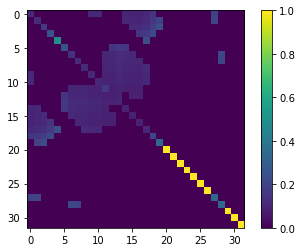

In [36]:
transform = Img2Graph()
X, A_tilde = transform(myfile)
plt.imshow(A_tilde)
plt.colorbar()

## Dataset Class

In [77]:
# Reads npy data
class DatasetGraph(Dataset):
    def __init__(
        self,
        input_dir,
        annotations_dir=None,
        transform=None,
        target_transform=None,
    ):
        start = time.time()
        self.input_dir = input_dir
        self.annotations_dir = annotations_dir
        # transformation is Identity transformation if transformation is None.
        self.transform = (lambda x: x) if transform is None else transform
        self.target_transform = target_transform
        self.input_files = sorted(os.listdir(self.input_dir))

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        input_X = torch.from_numpy(np.load(input_path))
        
        if len(input_X.shape) == 2:
            input_X = input_X.unsqueeze(axis=0)
        
        if self.transform:
            X, A_tilde = self.transform(input_X)

        # Ground truth if exists - we might use L1-ish data
        if self.annotations_dir is not None:
            annotations_path = os.path.join(
                self.annotations_dir, os.listdir(self.annotations_dir)[idx]
            )
            input_y = torch.load(annotations_path)
        elif input_X.shape[-1] == 6:
            input_y = input_X[:, :, :, -1]
        else:
            input_y = -1  # not using input_y

        return A_tilde, X, input_y # TODO: HOW TO EXPORT FEATURE MATRIX TOO?

In [78]:
graph_dataset = DatasetGraph(input_dir=input_dir, transform=Img2Graph())

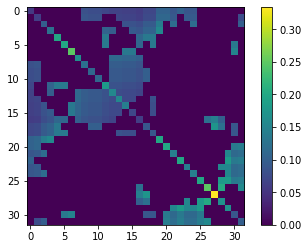

In [79]:
rand_sample_num = 13
plt.imshow(graph_dataset[rand_sample_num][0])
plt.colorbar()

## DataLoader Class

In [80]:
train_size = 50_000
train_ds, val_ds = torch.utils.data.random_split(graph_dataset, [train_size, len(graph_dataset)-train_size])
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True) # TODO: look for speedups i.e. pin memory? num_workers = # cpus
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [81]:
print(type(train_ds))
print(len(train_ds))

<class 'torch.utils.data.dataset.Subset'>
50000


In [82]:
for data in train_dl:
    break

3
torch.Size([32, 32, 32])
torch.Size([32, 1024, 3])
torch.Size([32])


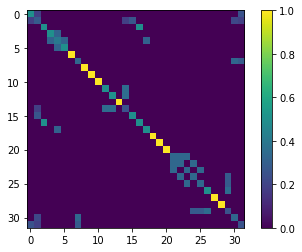

In [84]:
print(len(data))
print(data[0].shape) # A_tilde
print(data[1].shape) # X
print(data[2].shape) # input_y

# print(data[1])
sample_num = 14
plt.imshow(data[0][sample_num,:,:])
plt.colorbar()